# Maxcut by Quantum annealing

# 1. Graph definition

In [1]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt

import numpy as np

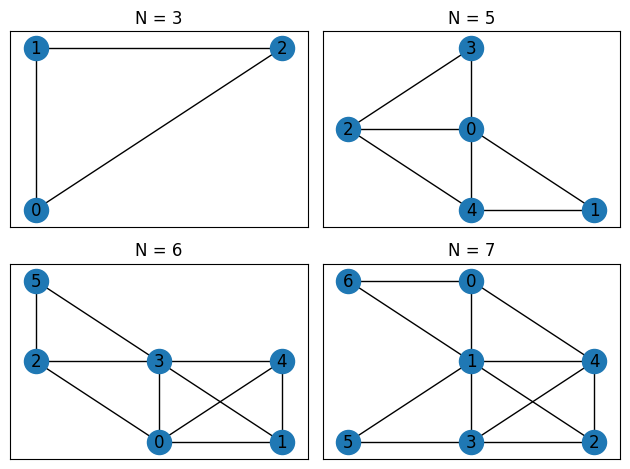

In [2]:
edgelists = [[(0, 1), (0, 2), (1, 2)], 
             [(0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4)], 
             [(0, 1), (0, 2), (0, 3), (0, 4), (1, 3), (1, 4), (2, 3), (2, 5), (3, 4), (3, 5)],
             [(0, 1), (0, 4), (0, 6), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 3), (2, 4), (3, 4), (3, 5)]]


coordinate_list = [[(0, 0), (0, 1), (1, 1)],
                   [(1, 1), (2, 0), (0, 1), (1, 2), (1, 0)],
                   [(1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (0, 2)],
                   [(1, 2), (1, 1), (2, 0), (1, 0), (2, 1), (0, 0), (0, 2)]]



G_set = [nx.from_edgelist(edgelist) for edgelist in edgelists]

list_matrice_J = []
for graphe in G_set:
    list_matrice_J.append(nx.to_numpy_array(graphe , dtype=int))

fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(fig.axes):
    pos = {n: pos for n, pos in enumerate(coordinate_list[i])}  
    nx.draw_networkx(G_set[i], pos, ax=ax)
    ax.set_title("N = {}".format(len(G_set[i].nodes())))

#fig.suptitle("Graphs of Interest")
plt.tight_layout()
plt.show()

# 2. Classical calculation

In [3]:
from itertools import combinations

def get_max_cut(G):
    """
    This function computes the max cut of a given graph.

    Input: Graph G

    Output: max_cut of the graph and associated partition
    """
    def two_partitions(lst):
        result = set()
        
        # Generate all possible combinations for the first subset
        for i in range(1, len(lst)):
            for part1 in combinations(lst, i):
                part1 = set(part1)
                part2 = set(lst) - part1  # The other subset is what remains
                # Add the partition to the set to avoid duplicates
                parti = frozenset([frozenset(part1), frozenset(part2)])
                result.add(parti)
        
        # Convert partitions to lists 
        return [list(map(list, parti)) for parti in result]
    
    partitions = two_partitions(range(len(G.nodes())))
    new_partitions = []

    for part in partitions:
        cut = 0
        for u in part[0]:
            for v in part[1]:
                if G.has_edge(u, v):
                    cut += 1

        # Add the partition with the cut count at the beginning
        new_partitions.append([cut] + part)

    max_cut = max(partition[0] for partition in new_partitions)
    max_cut_partitions = [partition for partition in new_partitions if partition[0] == max_cut]

    return max_cut, max_cut_partitions


In [4]:
for graph in G_set:
    print(get_max_cut(graph))

(2, [[2, [1, 2], [0]], [2, [1], [0, 2]], [2, [0, 1], [2]]])
(5, [[5, [3, 4], [0, 1, 2]], [5, [0, 3, 4], [1, 2]], [5, [1, 2, 3], [0, 4]], [5, [0, 2], [1, 3, 4]]])
(7, [[7, [1, 2, 4, 5], [0, 3]], [7, [0, 4, 5], [1, 2, 3]], [7, [1, 2, 4], [0, 3, 5]], [7, [0, 1, 5], [2, 3, 4]]])
(9, [[9, [2, 4, 5, 6], [0, 1, 3]]])


# 3. Quantum annealing gate based

The method consists of starting from a Hamiltonian that does not correspond to our graph but rather to a placement of the graph's points independently of each other; this is what we represent by the Hamiltonian $H_x$. Then, we construct an interaction Hamiltonian that maps the connections between the nodes of our graph, which we call the Hamiltonian $H_c$. The Hamiltonian $H_x$ has a well-known ground state. This method involves initializing the system in the ground state of the Hamiltonian $H_x$, then using the parameters $\eta$ to slowly evolve the Hamiltonian $H_{x}$ towards the Hamiltonian $H_c$. Since the evolution is slow, this ensures that the system remains in the ground state throughout the procedure, and thus, in the end, the system is in the ground state of the Hamiltonian associated with our graph $H_c$.

### The code
1. I create the function `u_x` which is the evolution operator of the Hamiltonian `hx`.
$$
H_x = \sum_{i}X_i
$$
$$
U_x = e^{-iH_{x}dt}
$$

2. I create the function `u_c` which is the evolution operator of the Hamiltonian `hc`.
$$
H_c = \sum_{i<j}J_{i,j}Z_{i}Z_{j}
$$
$$
U_c = e^{-iH_{c}dt}
$$

3. I create the function `U_init()` which creates a circuit that returns the ground state of `hx`.

4. I create the function `u_n` which applies the Suzuki-Trotter approximation of $U_{\eta}$. 
$$
U_{\eta} = \prod_{j = 1}^{\eta}exp\left(-i\left[\frac{j - 1}{\eta -1}H_{c} + \frac{\eta - j}{\eta -1}H_{x}\right]\right)
$$
With Suzuki-Trotter approximation we have:
$$
U_{\eta} \approx \prod_{j = 1}^{\eta}\left[U_{c}\left(\frac{j - 1}{m(\eta -1)}\right)U_{x}\left(\frac{\eta - j}{m(\eta -1)}\right)\right]^{m}
$$

We notice that at each iteration, as $\frac{j - 1}{m(\eta -1)}$ increases, $\frac{\eta - j}{m(\eta -1)}$ decreases, which reflects the transition from the Hamiltonian `hx` to `hc`.

5. The function `qaoa_circuit` simply initializes the circuit in the ground state of $H_{x}$ before applying `u_n`.

6. The function `ground_state_optimizer()` in this function, I use the qaoa_circuit function with the evolve method to retrieve the state vector of our circuit after the evolution of our system: $$\ket{\Phi_{\eta,m}} = U_{\eta , m}U_{init}\ket{0}$$ Then I calculate ``cost``, which is the eigenvalue of this state vector: $$C = \bra{\Phi_{\eta,m}}H_{c}\ket{\Phi_{\eta,m}}$$ then we perform optimization on C to make it as small as possible and thus obtain a good approximation of the ground state $\ket{\Phi_{\eta,m}}$. The optimization doesn't seem to work very well, probably because the increments of $\eta$ and ``m`` are integers. I could solve this problem for m by changing the way I construct the ``u_n`` circuit. I could first obtain the matrix corresponding to $$ U_{c}(\frac{j - 1}{m(\eta - 1)})U_{x}(\frac{\eta - j}{m(\eta - 1)})$$ Then apply the power m and transform the resulting matrix into an observable, and finally add it to the ``u_c`` circuit.

7. .
   
8. The function `calculate_maxcut_from_strings()` executes the final task. At this stage, I already have the bit string that corresponds to the partition of the maxcut. In fact, the "0" bits form one partition and the "1" bits form the other. For example, if I have "0101" with the order "0123", then the nodes from zero, namely {0, 2}, form one partition and {1, 3} form the other partition. It only remains to determine the number of edges that connect these partitions, which is the maxcut.

Unfortunately, I couldn't find a simple Python function to estimate the maxc for quick comparisonut.

Also, I notice a small bug at the end of execution. When I perform the following execution, I don't have any convergence. It's only after a third execution that I obtain results.keep the largest one.


In [5]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorSampler

from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2

from qiskit_ibm_runtime import EstimatorV2 as Estimator



## 3.1 Build $U_{x}$

In [6]:
def U_x(n, t):
    """
        input: n: nombre de qubit
               t: temps d'évolution
        ouput: QuantumCircuit
    """
    # Définir les matrices de Pauli et l'identité
    I = SparsePauliOp("I")
    X = SparsePauliOp("X")

    # Initialiser un opérateur total vide
    operator_total = None

    # Boucle pour créer les opérateurs et les additionner
    for i in range(n):
        A = [I] * n
        A[i] = X
        operator = A[0]
        
        for matrix in A[1:]:
            operator = operator ^ matrix
        if operator_total is None:
            operator_total = operator
        else:
            operator_total += operator

    # Construire la porte d'évolution
    evo = PauliEvolutionGate(operator_total, time=t)

    # Insérer dans un circuit
    circuit = QuantumCircuit(n)  # Le nombre de qubits doit correspondre à la longueur de A
    circuit.append(evo, range(n))

    return circuit

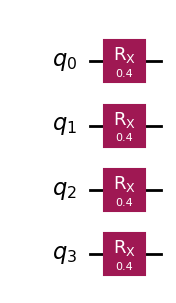

In [7]:
# Exemple d'utilisation de la fonction
n = 4
t = 0.2
circuit = U_x(n, t)
circuit.decompose().draw("mpl")

## 3.2 Build $U_c$

In [8]:
def U_c(n, J, t):
    # Définir les matrices de Pauli et l'identité
    """
    input: nombre de qubit
        branches du graphes
        temps d'évolution
    ouput: QuantumCircuit
    """
    I = SparsePauliOp("I")
    Z = SparsePauliOp("Z")

    # Initialiser un opérateur total vide
    operator_total = None

    # Boucle pour créer les opérateurs et les additionner
    for (i, j) in J:
        # Créer un vecteur de matrices I
        A = [I] * n
        # Remplacer les ième et jième éléments par Z
        A[i] = Z
        A[j] = Z
        # Initialiser l'opérateur avec la première matrice du vecteur
        operator = A[0]
        # Boucle pour effectuer les produits tensoriels
        for matrix in A[1:]:
            operator = operator ^ matrix
        # Additionner les opérateurs
        if operator_total is None:
            operator_total = operator
        else:
            operator_total += operator

    # Construire la porte d'évolution
    evo = PauliEvolutionGate(operator_total, time=t)

    # Insérer dans un circuit
    circuit = QuantumCircuit(n)  # Le nombre de qubits doit correspondre à la longueur de A
    circuit.append(evo, range(n))

    return circuit

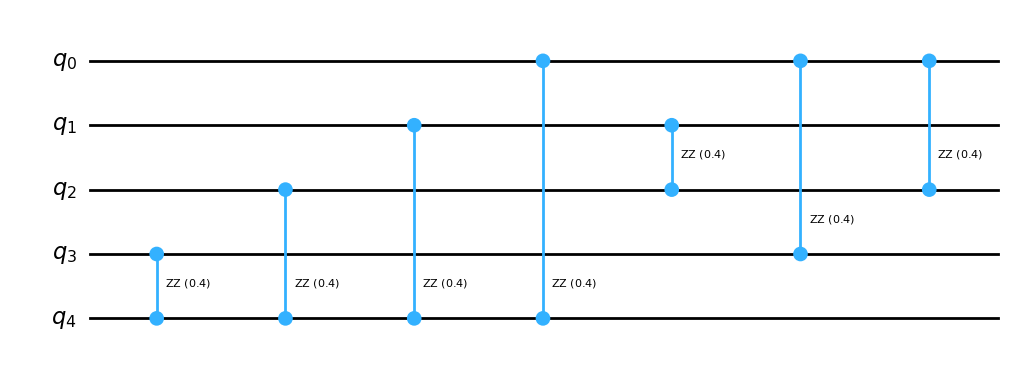

In [9]:
# Exemple d'utilisation de la fonction
n = 5
adjence_matrix = edgelists[1]
t = 0.2
circuit = U_c(n, adjence_matrix, t)
circuit.decompose().draw("mpl")

## 3.3 Build $U_{\eta}$

In [10]:
def U_n(neta: int, m: int , nombre_de_qubit, graphe):
    circuit = QuantumCircuit(nombre_de_qubit)
    
    for j in range(1, neta + 1):
        t_c = (j - 1) / (m * (neta - 1))
        t_x = (neta - j) / (m * (neta - 1))
        
        
        Uc = U_c(nombre_de_qubit, graphe, t_c)
        Ux = U_x(nombre_de_qubit, t_x)
        
        circuit_de_base = QuantumCircuit(nombre_de_qubit)
        circuit_de_base = circuit_de_base.compose(Uc)
        circuit_de_base = circuit_de_base.compose(Ux)
        
        for i in range(m - 1):
            circuit_de_base = circuit_de_base.compose(Uc)
            circuit_de_base = circuit_de_base.compose(Ux)
        
        circuit = circuit.compose(circuit_de_base)
    
    return circuit

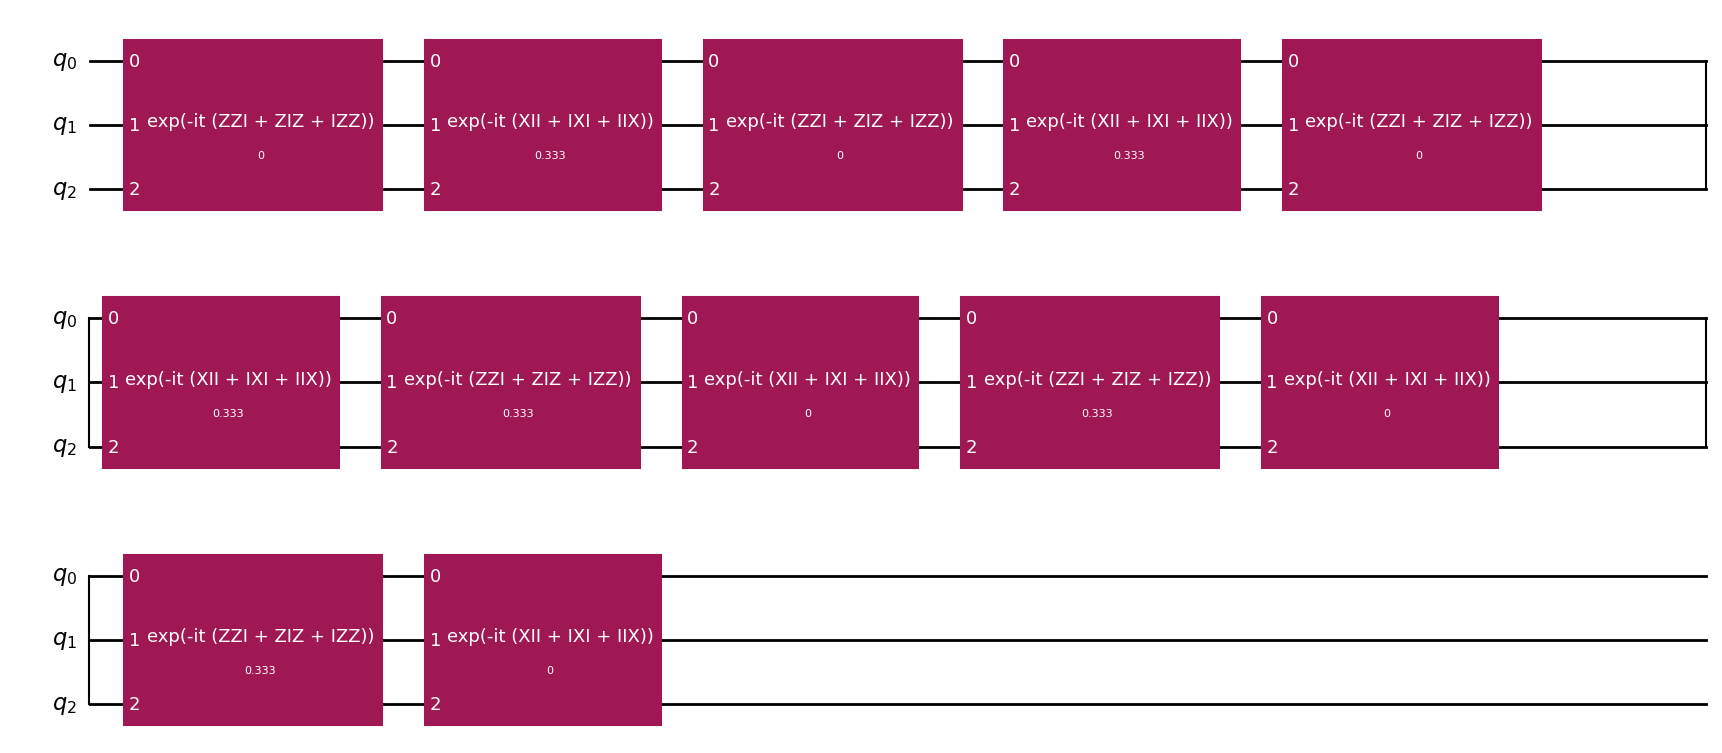

In [11]:
circuit = U_n(neta = 2 , m = 3 , nombre_de_qubit= 3 , graphe= edgelists[0])
circuit.draw("mpl")

## 3.4 Initializatiion of the circuit

In [12]:
def U_init(nombre_de_qubit):
    qc = QuantumCircuit(nombre_de_qubit)
    qc.x(range(nombre_de_qubit))
    qc.h(range(nombre_de_qubit))
    
    return qc

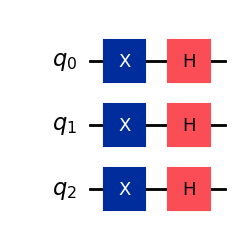

In [13]:
U_init(3).draw('mpl')

## 3.5 Quantum annealing solver

In [14]:
def qa_solver(graphe , neta , m):
    nombre_de_qubit = graphe.number_of_nodes()
    J = graphe.edges() #list(G.edges())
    qc = QuantumCircuit(nombre_de_qubit)
    qc = qc.compose(U_init(nombre_de_qubit))
    qc = qc.compose(U_n(neta , m , nombre_de_qubit , J))
    qc.measure_all()
    pub = (qc)
    sampler = StatevectorSampler()
    job_sampler =sampler.run([pub] , shots = 1024)

    result_sampler = job_sampler.result()
    counts_sampler = result_sampler[0].data.meas.get_counts()
    # print(counts_sampler)
    # plot_histogram(counts_sampler)
    #for i in 
    return counts_sampler

In [15]:
list_result = []
for g in G_set:
    list_result.append(qa_solver(g , 50 , 15))

# 4 Post-processing and formatting

bits string: 010
Set 1: [0, 2]
Set 2: [1]

bits string: 110
Set 1: [2]
Set 2: [0, 1]

bits string: 100
Set 1: [1, 2]
Set 2: [0]



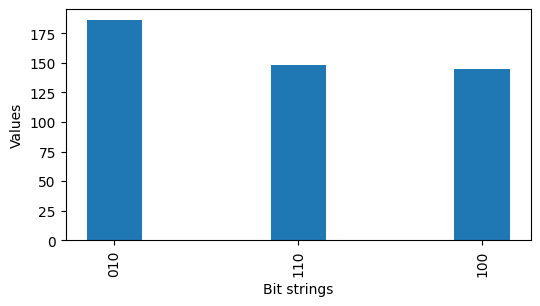

bits string: 10011
Set 1: [1, 2]
Set 2: [0, 3, 4]

bits string: 00011
Set 1: [0, 1, 2]
Set 2: [3, 4]

bits string: 01110
Set 1: [0, 4]
Set 2: [1, 2, 3]

bits string: 01011
Set 1: [0, 2]
Set 2: [1, 3, 4]



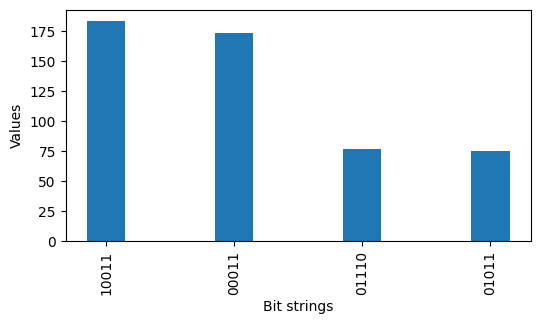

bits string: 011010
Set 1: [0, 3, 5]
Set 2: [1, 2, 4]

bits string: 011011
Set 1: [0, 3]
Set 2: [1, 2, 4, 5]

bits string: 011100
Set 1: [0, 4, 5]
Set 2: [1, 2, 3]

bits string: 110001
Set 1: [2, 3, 4]
Set 2: [0, 1, 5]



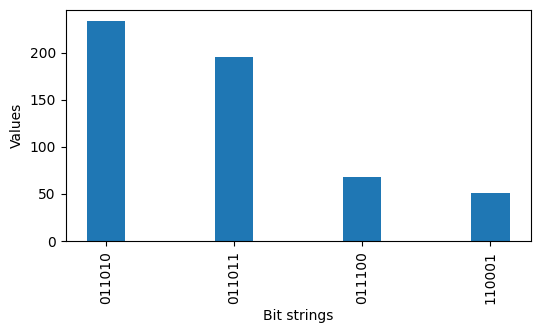

bits string: 1101000
Set 1: [2, 4, 5, 6]
Set 2: [0, 1, 3]

bits string: 1010010
Set 1: [1, 3, 4, 6]
Set 2: [0, 2, 5]

bits string: 1011011
Set 1: [1, 4]
Set 2: [0, 2, 3, 5, 6]

bits string: 1010011
Set 1: [1, 3, 4]
Set 2: [0, 2, 5, 6]

bits string: 1011000
Set 1: [1, 4, 5, 6]
Set 2: [0, 2, 3]



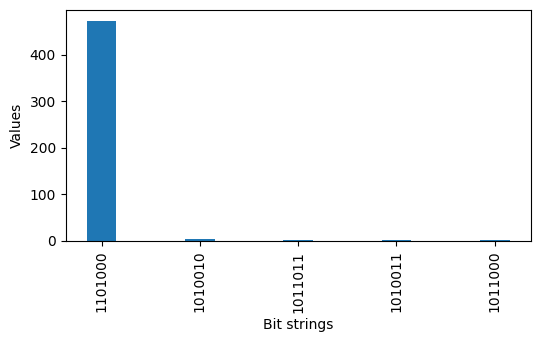

In [17]:
def remove_complementary_bits(bit_dict):
    # Dictionary to store without redundancy
    unique_bits = {}
    
    for bits, value in bit_dict.items():
        # Generate the complement
        complement = ''.join('1' if b == '0' else '0' for b in bits)
        # If the complement is in unique_bits, do not add bits
        if complement in unique_bits:
            continue
        # Add bits to unique_bits
        unique_bits[bits] = value
    
    return unique_bits

def get_bit_positions(bit_string):
    # List of positions of 0s and 1s
    pos_zeros = [i for i, bit in enumerate(bit_string) if bit == '0']
    pos_ones = [i for i, bit in enumerate(bit_string) if bit == '1']
    return pos_zeros, pos_ones

def plot_top_5_histogram(bit_dict):
    # Remove redundant and complementary strings
    unique_bits = remove_complementary_bits(bit_dict)
    
    # Sort items by values and keep the top 5 largest
    top_10 = sorted(unique_bits.items(), key=lambda item: item[1], reverse=True)[:5]
    
    # Separate bit strings and values
    bit_strings, values = zip(*top_10)
    
    # Get positions of 0s and 1s for each bit string
    bit_positions = [get_bit_positions(bits) for bits in bit_strings]
    
    # Display the positions of 0s and 1s for each bit string
    for bit_string, (pos_zeros, pos_ones) in zip(bit_strings, bit_positions):
        print(f"bits string: {bit_string}")
        print(f"Set 1: {pos_zeros}")
        print(f"Set 2: {pos_ones}\n")
    
    # Plot the histogram
    plt.figure(figsize=(6, 3))
    plt.bar(bit_strings, values, width=0.3)
    plt.xlabel('Bit strings')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    plt.show()


# Plot the histogram and display bit positions
for r in list_result:
    plot_top_5_histogram(r)


We can clearly see that we find all the sets that yielded the maximum cut with the classical algorithm. However, it is important to keep in mind that we worked on a simulator and with small-sized graphs. On a real quantum computer, we would expect noisy solutions and, therefore, fewer occurrences.